<hr />

# <h1 align="center"> Bremen PV self-sufficiency feasbility study: workflow </h1>

<hr />
<center>A mini-project followed the SommerUni 2025 "Hack your CAD models"</center>
<h3 align="center">Sze-Wing To (Debbie)</h3>

*Research question: Can Bremen achieve energy self-sufficiency for heating consumption through rooftop photovoltaic installations to support its 2038 climate neutrality goal?*

Area definition: As a preliminiary project, only a number of residential areas in Bremen was considered. They are Ostertor, Steintor, Fesenfeld, Östliche Vorstadt, Huisberg, Peterswerder. The selection was due to its highly condensed Old Bremen houses in the Bremen city that represents a promising opportunity for PV implementation.

### 1. Export osm file from [OpenStreetMap](https://www.openstreetmap.org/#map=13/53.05561/8.81327).
<br>
The coordinates used for selects are shown in the screen cap in below.

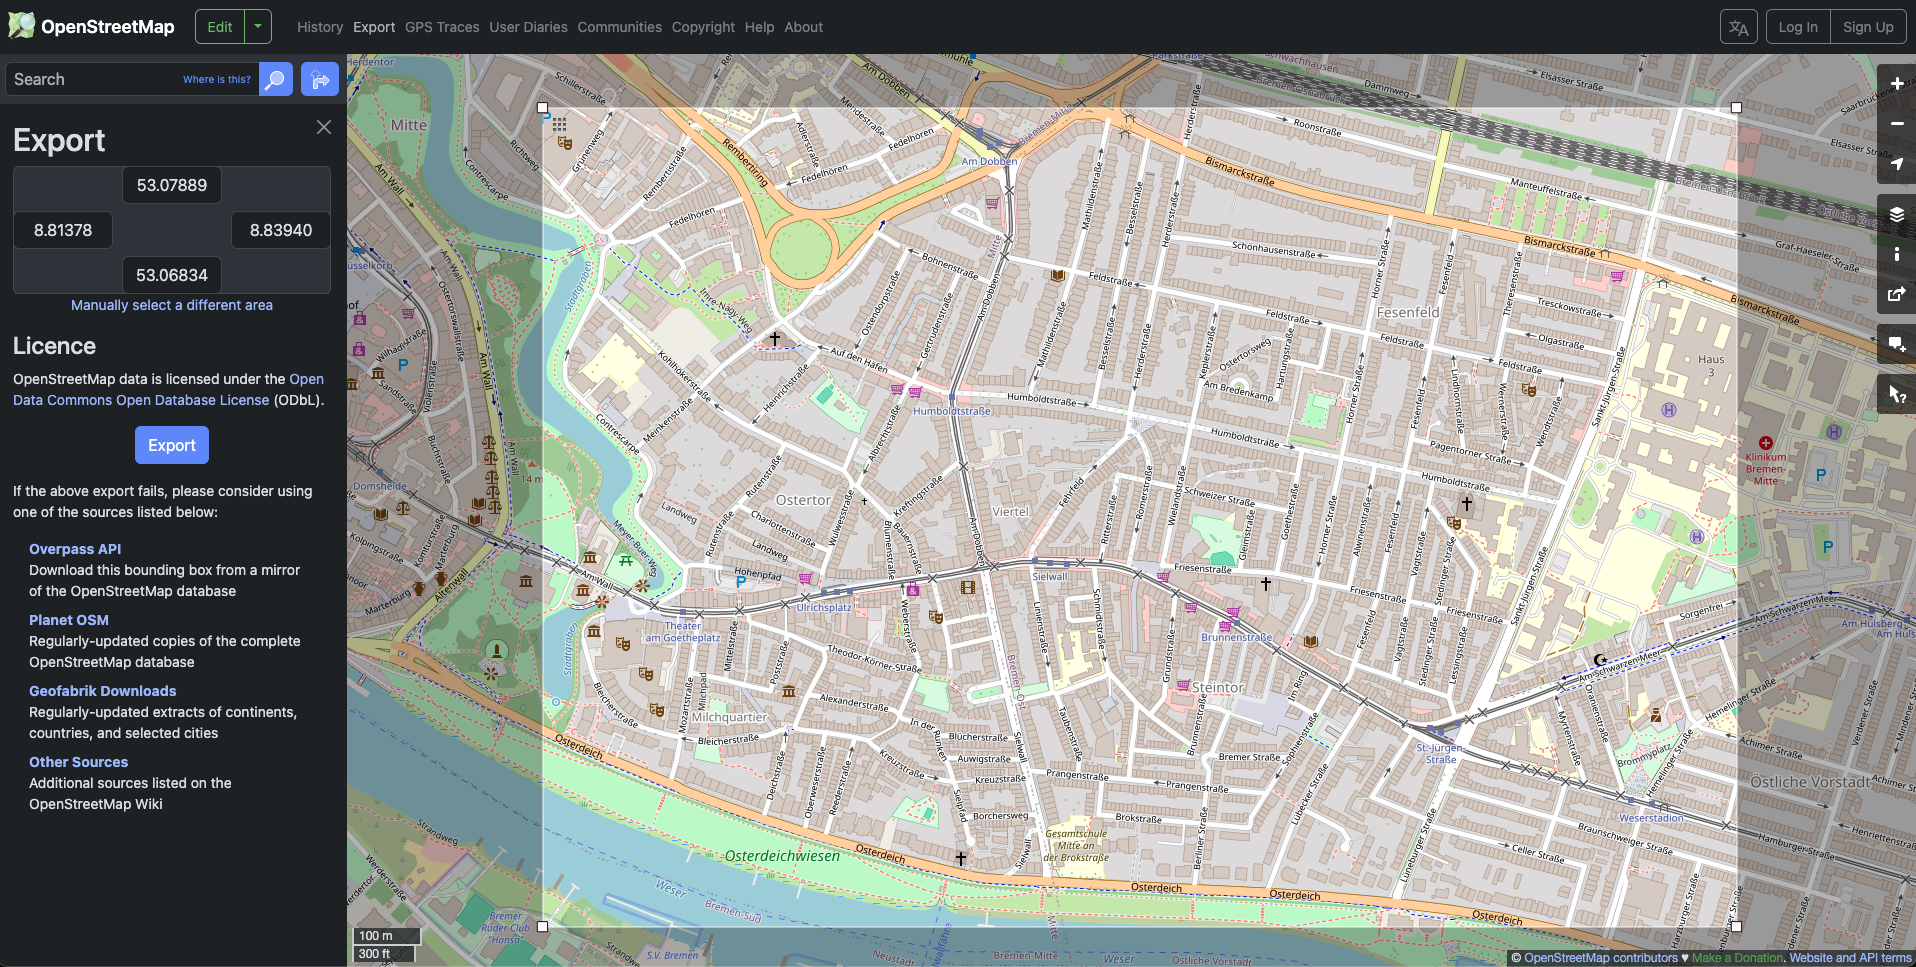

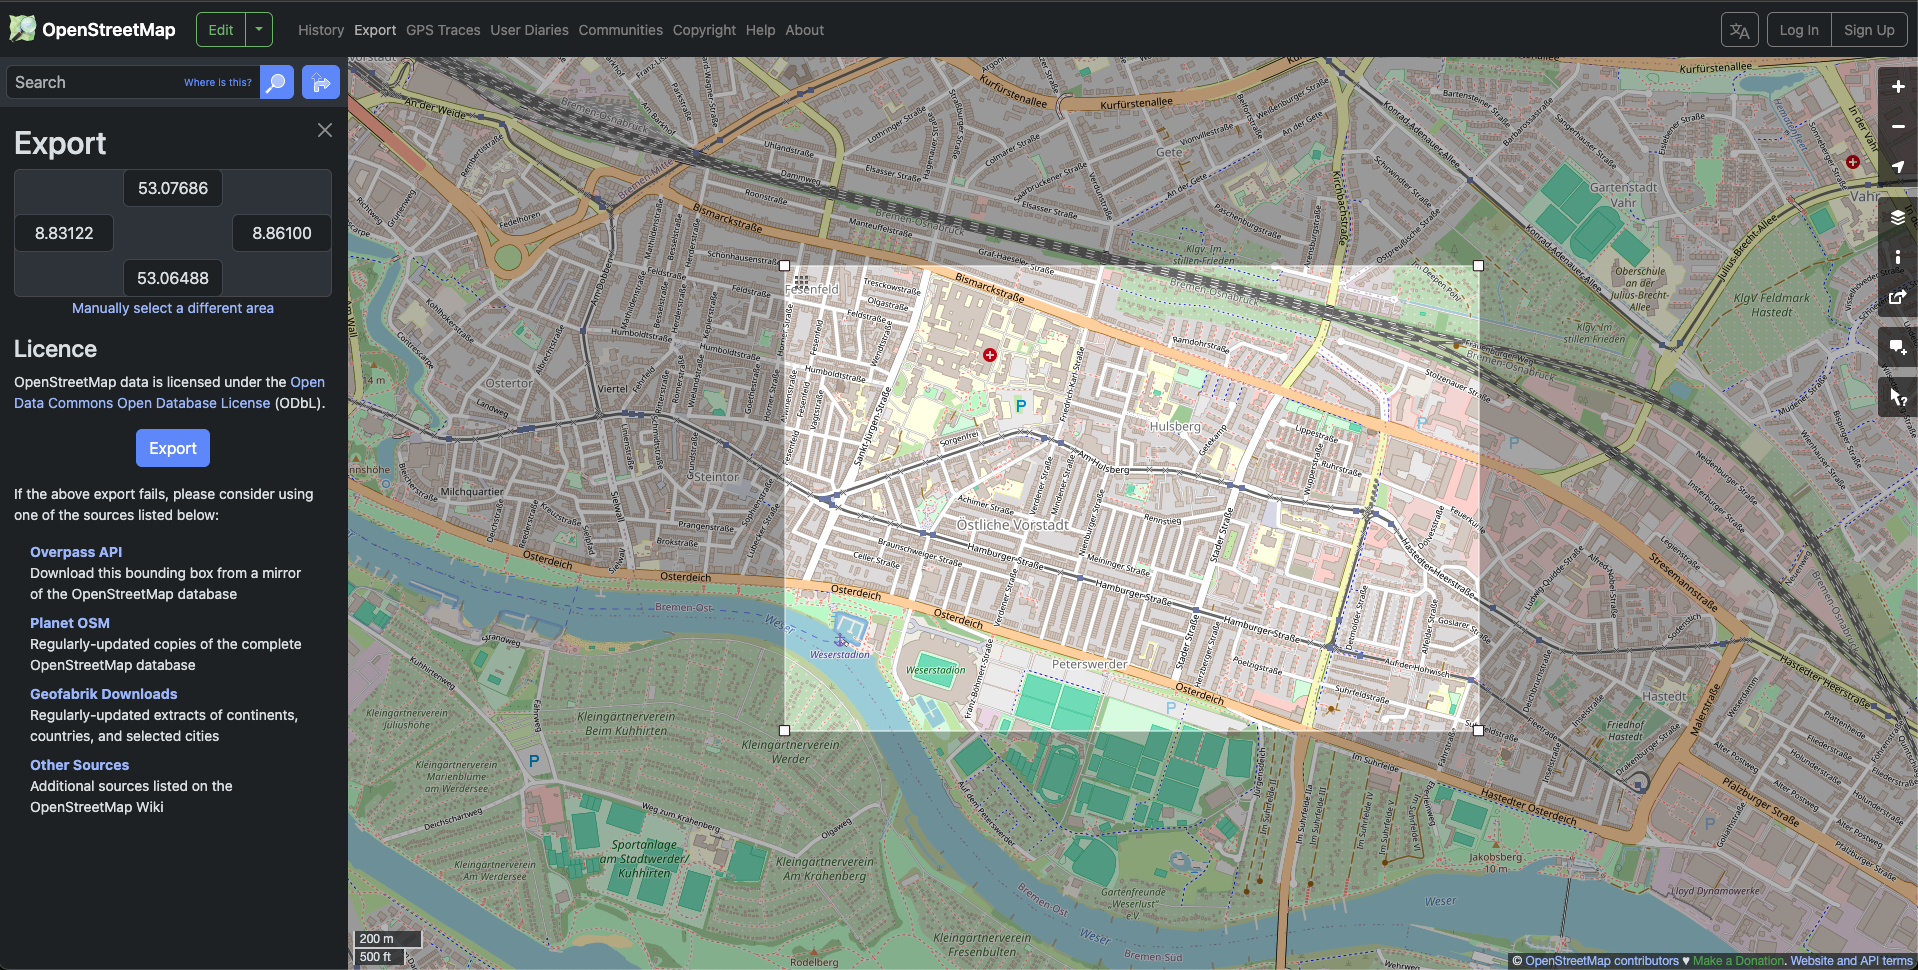

### 2. Transform OSM to DXF

To import drawing files to FreeCAD, I transformed the exported osm files to a dxf file. 
1. osm -> GeoJSON
- merging the osm files based on the lat/lon coordinates - obtained by parsing XML data
- extracting buildings from way tag (excluding other features like roads, transportation, leisure etc.)
<br><br>

In [1]:
import sys
from osm2dxf import merge_osm_buildings, write_geojson

# Define input and output files
osm_files = ['map1.osm', 'map2.osm']       # input osm
output_json = 'bremen.geojson'          # output geojson name
output_dxf = 'bremen.dxf'                  # output dxf name

all_buildings = merge_osm_buildings(osm_files)
count = write_geojson(all_buildings, output_json)
print(f"Created {count} building polygons and saved to {output_json}\n")

Created bremen.geojson - now run: ogr2ogr -f DXF output.dxf bremen.geojson
Created 9456 building polygons and saved to bremen.geojson



2. GeoJSON -> dxf
- create geometries (in polygon form) for extrusions in FreeCAD

In [2]:
! ogr2ogr -f DXF bremen.dxf bremen.geojson

### Data screening in FreeCAD
After importing dxf to FreeCAD, the data screening was first to exclude the buildings that are small community garden structures in the north and south of the map. There were 9333 items remained. The screening was followed by identifying non-residential buildings like supermarket (Rewe), schools, cultural facilities (museums), and industrial (Bauhaus, Deutsche Telekom) and public services (hospital, fire station). 
<br><br>
Then extruded the buildings for 10m. A total of 9295 buildings were extruded.

Common Macro used for FreeCAD:
<br><br>
- count selected items <br>
    ```Python
    len(FreeCADGui.Selection.getSelection())
    ```



- create face from wire and calculate areas 
<br> 
```Python
import FreeCAD
import Part

doc = FreeCAD.ActiveDocument

# make face to calculate areas
areas = []

for obj in doc.Objects:
    if obj.Label.startswith('Hatch'):
        try:
            # Try to create face from wire manually
            if obj.Shape.Wires:
                wire = obj.Shape.Wires[0]
                face = Part.Face(wire)
                areas.append(face.Area)
                print(f"{obj.Label}: {area:.2f} m²")
        except:
            print(f"{obj.Label}: Failed")

print(f"Total: {sum(areas):.2f} m², Count: {len(areas)}")
```

```python
Total: 954294.22 m², Count: 9295
```

## Calculation of rooftop PV generation 
##### Output total rooftop area for Bremen Houses: 0.95km2 (954294.22m2)
##### 3-year mean (2021-2023) heating consumption of Bremen city: 132.7 kWh/km2 

### Data entry according to data sheets

In [3]:
# load dependencies
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

plt.style.use("ggplot")

- 25_0_m: tilt 25 degree, south facing
- 50_0_m: tilt 50 degree, south facing
- 0_0_m: flat mounted
- 25_45_m: tilt 25 degree, 45 degree east of south
- 25_90_m: tilt 25 degree, east facing
<br><br>
- sd: the standard deviation values due to year-to-year fluctuations in solar conditions provided by PVGIS.

In [4]:
## create dataset (Average monthly energy production from the given system - 0.25kWp per m2 - output: kWh/month)

df = pd.DataFrame({
    'Month': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    '25_0_m':   [6.01, 10.93, 19.80, 28.56, 31.16, 31.18, 30.56, 27.61, 22.41, 15.02, 7.62, 5.13],
    '25_0_sd':  [0.92, 2.47, 3.51, 3.78, 3.90, 2.59, 3.76, 2.45, 2.67, 2.60, 1.35, 1.09],
    '50_0_m':   [7.62, 12.95, 21.27, 28.36, 28.84, 28.07, 27.88, 26.51, 23.35, 17.24, 9.48, 6.78],
    '50_0_sd':  [1.32, 3.26, 4.24, 4.09, 3.77, 2.38, 3.52, 2.51, 3.08, 3.34, 1.89, 1.59],
    '0_0_m':    [3.29, 6.98, 15.40, 24.99, 29.89, 30.96, 29.92, 25.34, 18.34, 10.31, 4.35, 2.47],
    '0_0_sd':   [0.33, 1.13, 2.08, 2.80, 3.45, 2.45, 3.45, 2.01, 1.75, 1.31, 0.49, 0.35],
    '25_45_m':  [5.13, 9.60, 18.50, 27.25, 30.30, 30.71, 29.95, 26.57, 21.03, 13.52, 6.63, 4.29],
    '25_45_sd': [0.74, 2.01, 3.06, 3.68, 3.60, 2.57, 3.73, 2.24, 2.49, 2.37, 1.15, 0.87],
    '25_90_m':  [3.39, 6.93, 15.25, 23.91, 28.28, 29.30, 28.38, 24.07, 17.79, 10.26, 4.48, 2.58],
    '25_90_sd': [0.37, 1.11, 2.03, 2.92, 3.09, 2.38, 3.38, 1.82, 1.84, 1.55, 0.59, 0.40]
})
df


Month  25_0_m  25_0_sd  50_0_m  50_0_sd  0_0_m  0_0_sd  25_45_m  25_45_sd  \
0    Jan    6.01     0.92    7.62     1.32   3.29    0.33     5.13      0.74   
1    Feb   10.93     2.47   12.95     3.26   6.98    1.13     9.60      2.01   
2    Mar   19.80     3.51   21.27     4.24  15.40    2.08    18.50      3.06   
3    Apr   28.56     3.78   28.36     4.09  24.99    2.80    27.25      3.68   
4    May   31.16     3.90   28.84     3.77  29.89    3.45    30.30      3.60   
5    Jun   31.18     2.59   28.07     2.38  30.96    2.45    30.71      2.57   
6    Jul   30.56     3.76   27.88     3.52  29.92    3.45    29.95      3.73   
7    Aug   27.61     2.45   26.51     2.51  25.34    2.01    26.57      2.24   
8    Sep   22.41     2.67   23.35     3.08  18.34    1.75    21.03      2.49   
9    Oct   15.02     2.60   17.24     3.34  10.31    1.31    13.52      2.37   
10   Nov    7.62     1.35    9.48     1.89   4.35    0.49     6.63      1.15   
11   Dec    5.13     1.09    6.78     1.59   2.47    0.35     4.29      0.87   

    25_90_m  25_90_sd  
0      3.39      0.37  
1      6.93      1.11  
2     15.25      2.03  
3     23.91      2.92  
4     28.28      3.09  
5     29.30      2.38  
6     28.38      3.38  
7     24.07      1.82  
8     17.79      1.84  
9     10.26      1.55  
10     4.48      0.59  
11     2.58      0.40

In [5]:
test = df[['25_0_m', '50_0_m', '0_0_m', '25_45_m', '25_90_m']]
error = df[['25_0_sd', '50_0_sd', '0_0_sd', '25_45_sd', '25_90_sd']]

In [6]:
# df.to_csv('Bremen_PV_yield.csv', index=False)

/var/folders/37/hmn4ydl96cg8b39lc8lbkxw80000gp/T/ipykernel_88440/1740190804.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(np.arange(0, 38, 5), fontsize=13);


25_0_m - standard parameter set


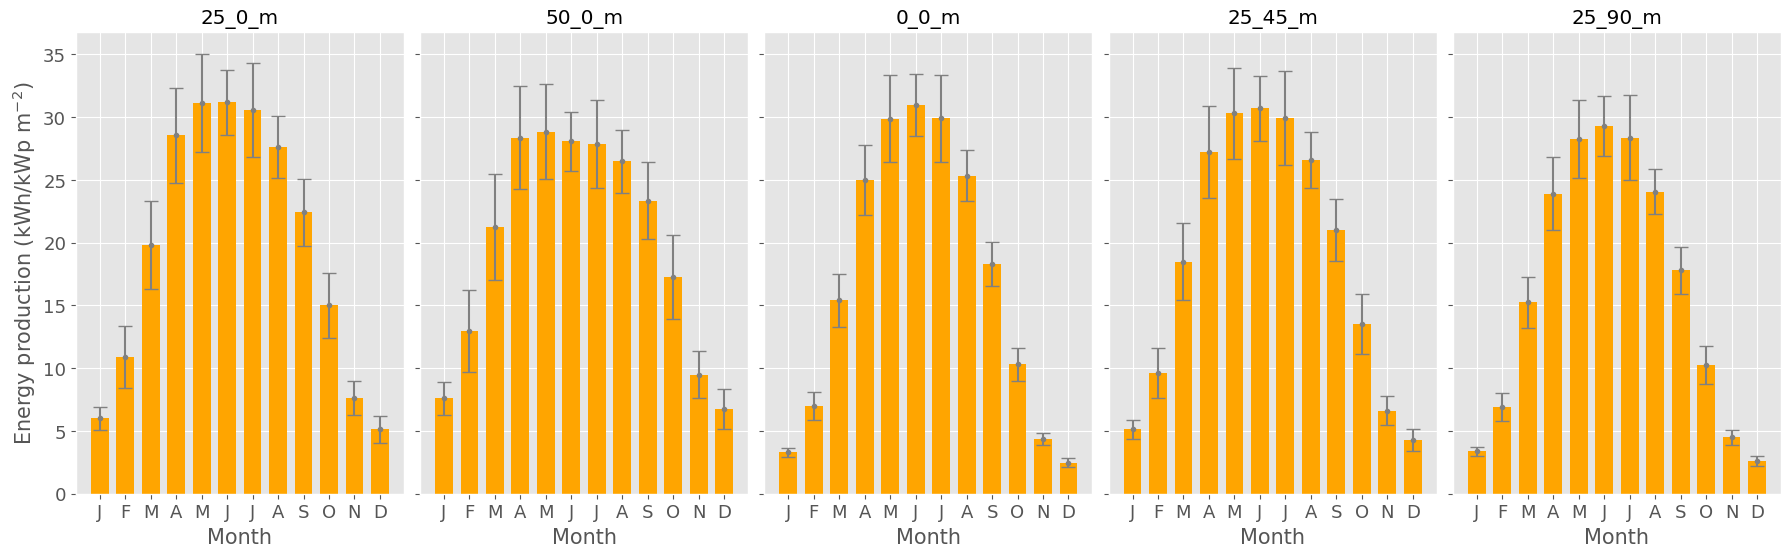

In [7]:
fig, axs = plt.subplots(1, 5, figsize=(22, 6), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05)
axs.flatten()
for i in range(5):
    axs[i].bar(df['Month'], test.iloc[:, i], color='orange', width=0.7)
    axs[i].errorbar(df['Month'], test.iloc[:, i], yerr=error.iloc[:, i], fmt='.', color='gray', capsize=5)
    axs[i].set_title(test.columns[i])
    axs[i].set_xlabel('Month', fontsize=15)
    axs[i].set_xticks(df['Month'])
    axs[i].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'], fontsize=13)
axs[0].set_ylabel('Energy production (kWh/kWp m$^{-2}$)', fontsize=15)
axs[0].set_yticklabels(np.arange(0, 38, 5), fontsize=13);
None
print("25_0_m - standard parameter set")

In [8]:
test_list = test.columns.tolist()
test_list

['25_0_m', '50_0_m', '0_0_m', '25_45_m', '25_90_m']

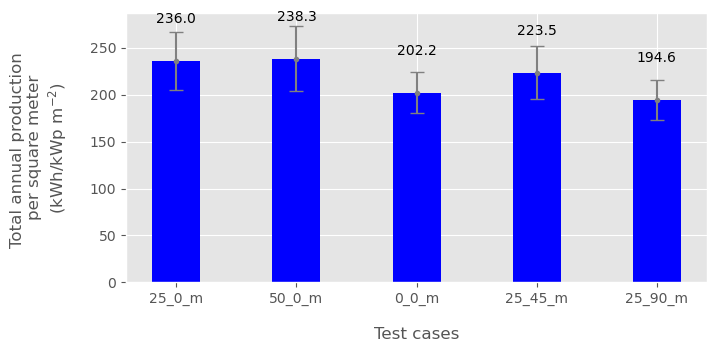

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(7.5, 3.5))
axs.bar(test_list, test.sum().values, color='blue', width=0.4)
axs.errorbar(test_list, test.sum().values, error.sum().values, fmt='.', color='gray', capsize=5)
# axs.set_ylim(0, 200)
axs.set_ylabel('Total annual production \nper square meter\n(kWh/kWp m$^{-2}$)', labelpad=15)
axs.set_xlabel('Test cases', labelpad=15)
axs.bar_label(axs.containers[0], fmt='%.1f', padding=25);

In [10]:
tot_area_m2 = 954294.22             # total rooftop area for Bremen Houses in m2
rooftop_usable_area = 0.75          # assume 75% of rooftop area is usable for PV installation
tot_usable_area_km2 = tot_area_m2 * rooftop_usable_area / 1e6       # from m2 to km2

print(f"Total usable rooftop area for PV installation: {tot_usable_area_km2:.2f} km2")

Total usable rooftop area for PV installation: 0.72 km2


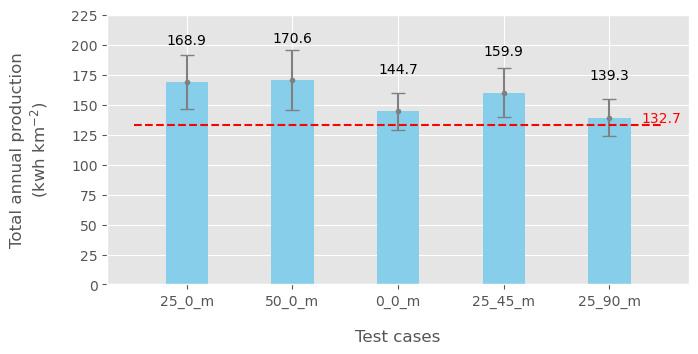

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(7.5, 3.5))
axs.bar(test_list, test.sum().values*tot_usable_area_km2, color='skyblue', width=0.4)
axs.errorbar(test_list, test.sum().values*tot_usable_area_km2, error.sum().values*tot_usable_area_km2, fmt='.', color='gray', capsize=5)
axs.set_ylim(0, 225)
axs.hlines(132.7, xmin=-0.5, xmax=4.5, color='red', linestyle='--', label='3-year mean heating consumption (132.7 kWh/km2)')
axs.text(4.3, 135, '132.7', color='red')
axs.set_ylabel('Total annual production\n(kwh km$^{-2}$)', labelpad=15)
axs.set_xlabel('Test cases', labelpad=15)
axs.bar_label(axs.containers[0], fmt='%.1f', padding=25);

The result shows that a flat-mounted PV panel (0_0_m) has lower total annual PV generation than tilted panels (25_0_m and 50_0_m) and the optimal mounting slope is possibly between 25 and 50 degree. Given a default mounting slope of 25 degree, the PV panel facting south-west (25_45_m) can harvest more energy than facing south (25_0_m) and facing west (25_90_m).
<br><br>
This above result, interpreted in terms of kWh km-2, however, is based on an important assumption, where only one storey of the building is heated up. Assuming normal Bremem houses with three-storey, the number of storey using heating determined the PV potential. 

### No. of building storey heating up determined total energy usage

In [12]:
rooftop_area = 0.95
heating_area = rooftop_area * 0.8 * 3
        # assuming 20% of building footprint for construction elements e.g., walls, structural limitations
heating_per_km2 = 132.7            # kWh/km2
tot_heating = heating_per_km2 * heating_area
print(f"Assuming heating up a 3-storey building, ")
print(f"total heating area is {heating_area:.1f}km2, ")
print(f"total annual energy consumption is {tot_heating:.1f}kWh")
print(f"standard PV production is {test.sum().values[0] * tot_usable_area_km2:.1f}kWh")        # one layer of PV production

Assuming heating up a 3-storey building, 
total heating area is 2.3km2, 
total annual energy consumption is 302.6kWh
standard PV production is 168.9kWh


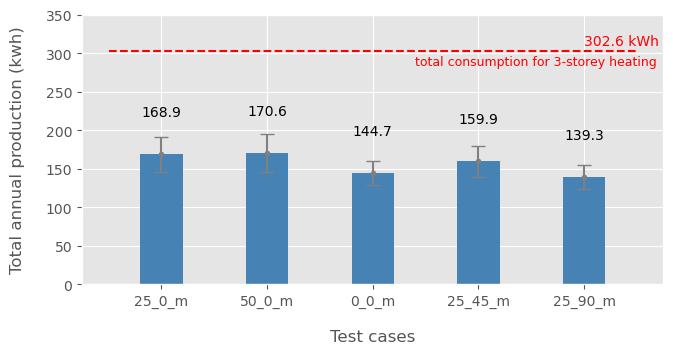

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(7.5, 3.5))
axs.bar(test_list, test.sum().values*tot_usable_area_km2, color='steelblue', width=0.4)
axs.errorbar(test_list, test.sum().values*tot_usable_area_km2, error.sum().values*tot_usable_area_km2, fmt='.', color='gray', capsize=5)
axs.set_ylim(0, 350)
axs.hlines(tot_heating, xmin=-0.5, xmax=4.5, color='red', linestyle='--')
axs.text(4, 310, f"{tot_heating:.1f} kWh", color='red')
axs.text(2.4, 285, 'total consumption for 3-storey heating', color='red', fontsize=9)
axs.set_ylabel('Total annual production (kwh)', labelpad=15)
axs.set_xlabel('Test cases', labelpad=15)
axs.bar_label(axs.containers[0], fmt='%.1f', padding=25);

When interpreting results in terms of full heating consumption for 3-storey, the PV production will be in short of the heating demands for all testing cases. This suggests that both heating demand patterns and detailed configurations for PV production are critical to further evaluate the PV potential for Bremen houses.